# TRABALHO 1 LabIACD

### Desenvolvido por:
        -Francisco tavares
        -Guilherme Oliveira
        -Rodrigo Batista
        -Rodrigo Taveira

<a id="indice"></a>
## √çndice

1. [Introdu√ß√£o](#introducao)

2. [Objetivo](#objetivo)

3. [Pr√© processamento 1](#pre-processamento-1)

4. [Cria√ß√£o do noduledf](#criacao-do-noduledf)

5. [Isolar nodulos e cria√ß√£o de m√°scaras 2D](#isolar-nodulos-e-criacao-de-mascaras-2d)

6. [Visualiza√ß√£o das m√°scaras 2D e extra√ß√£o de features](#visualizacao-das-mascaras-2d-e-extracao-de-features)

7. [M√°scaras 3D](#mascaras-3d)

8. [Extra√ß√£o das features](#extracao-das-features)

9. [Pr√© Processamento 2](#pre-processamento-2)

10. [Feature Selection](#feature-selection)

11. [Modelos ML](#modelos-ml)

12. [Discuss√£o dos resultados 1](#discussao-dos-resultados-1)

13. [Discuss√£o dos resultados 2](#discussao-dos-resultados-2)

14. [Conclus√£o](#conclusao)



<a id="introducao"></a>
## Introdu√ß√£o

[Go back to the top](#indice)

Este trabalho tem como objetivo explorar e documentar o processo de an√°lise de imagens de tomografia computadorizada (CT) do t√≥rax, focado na avalia√ß√£o do risco de malignidade de n√≥dulos pulmonares, a partir do uso do dataset p√∫blico LIDC-IDRI. Utilizando bibliotecas amplamente reconhecidas como pylidc e Pyradiomics, o nosso objetivo √© extrair e analisar caracter√≠sticas quantitativas das imagens.

Este projeto, desenvolvido no √¢mbito da disciplina de Laborat√≥rio de Intelig√™ncia Artificial e Ci√™ncia de Dados (Lab AI & DC), permitir√° a aplica√ß√£o de metodologias de ci√™ncia de dados e desenvolvimento de software adquiridas em disciplinas anteriores. 

A organiza√ß√£o do notebook em t√≥picos bem estruturados facilita o acesso √†s etapas principais do trabalho, conforme apresentado no √≠ndice.

<a id="objetivo"></a>
## Objetivo

[Go back to the top](#indice)

O objetivo central √© utilizar as t√©cnicas e ferramentas estudadas para analisar n√≥dulos pulmonares com base no dataset LIDC-IDRI, buscando, atrav√©s das features extra√≠das, avaliar automaticamente o risco de malignidade dos n√≥dulos

In [5]:
import pandas as pd
import pylidc as pl
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import os
from radiomics import featureextractor
import shutil
import sys
import statistics
from skimage.transform import resize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
import SimpleITK as sitk


<a id="pre-processamento-1"></a>
## Pr√© processamento 1

[Go back to the top](#indice)

Inicialmente iremos come√ßar por remover todos os pacientes que n√£o t√™m anota√ß√µes associadas. Para isso iremos percorrer todos os pacientes e os que n√£o tiverem anota√ß√µes ser√£o removidos e escritos num ficheiro de texto "deleted_patients.txt"

In [6]:
input_directory = "C:\\Users\\admin\\Desktop\\Laboratorios\\manifest-1729376398075\\LIDC-IDRI"

deleted_patients = []

patient_folders = sorted(os.listdir(input_directory))

for patient_folder in patient_folders:
    patient_folder_path = os.path.join(input_directory, patient_folder)

    # Id de cada paciente - 'LIDC-IDRI-xxxx'
    patient_id = os.path.basename(patient_folder_path)
    
    patient_scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id)
    
    for scan in patient_scans:
        anns = scan.annotations
        
        if not anns:
            # O caminho at√© os pacientes que queremos eliminar
            delete_folder = os.path.join(input_directory, patient_id) 

            if os.path.exists(delete_folder):
                if os.path.isdir(delete_folder):
                    # Remove recursivamente j√° que o paciente n√£o tem anota√ß√µes
                    shutil.rmtree(delete_folder)
                    print(f"O paciente '{patient_id}' foi removido por n√£o ter anota√ß√µes")
                    deleted_patients.append(patient_id)
                else:
                    print(f"'{patient_id}' n√£o √© um ficheiro.")
            else:
                print(f"O paciente '{patient_id}' n√£o existe.")
 
folder = "deleted_patients.txt"

with open(folder, 'w') as arquivo:
    # fun√ß√£o para escrever num ficheiro os pacientes eliminados
    for element in deleted_patients:
        arquivo.write(element + '\n')

Neste bloco verificamos se h√° muitos pacientes com mais de um scan. Como o n√∫mero √© bastante reduzido apenas iremos considerar o primeiro scan de todos os pacientes

In [7]:
patient_scan_count = {}

patients = pl.query(pl.Scan).distinct(pl.Scan.patient_id).all()

# Aqui contamos quantos scans tem cada paciente
for patient in patients:
    scan_count = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient.patient_id).count()
    patient_scan_count[patient.patient_id] = scan_count

# Filtramos os pacientes com mais de um scan
patients_with_multiple_scans = {patient_id: count for patient_id, count in patient_scan_count.items() if count > 1}

# Convertemos para dataframe se quiserem guardar num ficheiro √† parte
multiple_scans_df = pd.DataFrame(patients_with_multiple_scans.items(), columns=['PatientID', 'ScanCount'])

# Salvar o DataFrame em um arquivo CSV
#multiple_scans_df.to_csv('C:\\Users\\admin\\Desktop\\Laboratorios\\patients_with_multiple_scans.csv', index=False)

print(multiple_scans_df)


C:\Users\admin\AppData\Local\Temp\ipykernel_9172\2833829615.py:3: SADeprecationWarning: DISTINCT ON is currently supported only by the PostgreSQL dialect.  Use of DISTINCT ON for other backends is currently silently ignored, however this usage is deprecated, and will raise CompileError in a future release for all backends that do not support this syntax.
  patients = pl.query(pl.Scan).distinct(pl.Scan.patient_id).all()


        PatientID  ScanCount
0  LIDC-IDRI-0132          2
1  LIDC-IDRI-0151          2
2  LIDC-IDRI-0315          2
3  LIDC-IDRI-0332          2
4  LIDC-IDRI-0355          2
5  LIDC-IDRI-0365          2
6  LIDC-IDRI-0442          2
7  LIDC-IDRI-0484          2


<a id="criacao-do-noduledf"></a>
## Cria√ß√£o do noduledf

[Go back to the top](#indice)

Nesta etapa iremos proceder √† cria√ß√£o de um dataset com as anota√ß√µes de cada paciente.

Sabemos que cada paciente pode ter v√°rios n√≥dulos, e estes por sua vez podem ter v√°rias anota√ß√µes de v√°rios radiologistas. Tendo isto em mente para n√£o termos v√°rias anota√ß√µes para o mesmo n√≥dulo, decidimos agrupa-las inicialmente por moda e em caso de empate (por exemplo, 1 1 5 5) pela m√©dia inteira. Como h√° atributos em que valores n√£o representam uma escala mas sim caracter√≠sticas n√£o relacionadas, definimos uma fun√ß√£o para nesses atributos selecionar o primeiro valor.

Baseamos a nossa escolha destas t√©cnicas em v√°rias refer√™ncias como o artigo de S. G. Armato et al., "The Lung Image Database Consortium (LIDC) and Image Database Resource Initiative (IDRI): A completed reference database of lung nodules on CT scans," Medical Physics, 2011 e o artigo de J. L. Causey et al., "Highly accurate model for prediction of lung nodule malignancy with CT scans," Scientific Reports, 2018 que embora n√£o digam explicitamente quais m√©todos usaram, a moda e a m√©dia s√£o bastante comuns para consolidar caracter√≠sticas dadas por v√°rios observadores.

Criamos tamb√©m um nodule_id para podermos acessar essas anota√ß√µes mais facilmente e para poder juntar as features extraidas do radiomics a este dataset


In [8]:
'''
# C√≥digo para evitar erros com a vers√£o do numpy instalada
np.int=np.int64

# Fun√ß√£o para calcular moda ou m√©dia
def moda_ou_media(valores):
    try:
        # Tenta calcular a moda
        return statistics.mode(valores)
    except statistics.StatisticsError:
        # Se n√£o houver moda, calcula a m√©dia
        return np.mean(valores)
    
def moda_ou_primeiro(valores):
    #print(valores)
    try:
        # Tenta calcular a moda
        return statistics.mode(valores)
    except statistics.StatisticsError:
        # Se n√£o houver moda, calcula a m√©dia
        return valores[0]

# Criamos uma lista para armazenar as informa√ß√µes de cada n√≥dulo
nodule_data = []

nodule_id=0

for i in range(1, 1013): 
    patient_id = f"LIDC-IDRI-{i:04d}"  # Formato do ID com zeros √† esquerda

    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).first()

    if scan is None:
        print("NAO H√Å SCAN PARA ESTE PACIENTE ", patient_id)

    else:
        patient_id = scan.patient_id

        # Come√ßamos por iterar sobre os n√≥dulos do paciente
        for nodule_list in scan.cluster_annotations():
            nodule_id+=1
            #print(nodule_list)
            if len(nodule_list) > 0:
                # Inicializamos listas para armazenar as caracter√≠sticas dos radiologistas
                internal_structure_list = []
                sphericity_list = []
                calcification_list = []
                subtlety_list = []
                lobulation_list = []
                margin_list = []
                spiculation_list = []
                texture_list = []
                malignancy_list = []

                # Neste ciclo iteramos sobre as anota√ß√µes dos radiologistas
                for nodule in nodule_list:
                    internal_structure_list.append(nodule.internalStructure)
                    sphericity_list.append(nodule.sphericity)
                    calcification_list.append(nodule.calcification)
                    subtlety_list.append(nodule.subtlety)
                    lobulation_list.append(nodule.lobulation)
                    margin_list.append(nodule.margin)
                    spiculation_list.append(nodule.spiculation)
                    texture_list.append(nodule.texture)
                    malignancy_list.append(nodule.malignancy)

                # Para cada caracter√≠stica, aplicamos a fun√ß√£o moda ou m√©dia (ou apenas o primeiro valor)
                nodule_data.append({
                    'PatientID': patient_id,
                    'NoduleID': nodule_id,  # Assume que todos os n√≥dulos no cluster t√™m o mesmo ID
                    'InternalStructure': moda_ou_primeiro(internal_structure_list),
                    'Sphericity': moda_ou_media(sphericity_list),
                    'Calcification': moda_ou_primeiro(calcification_list),
                    'Subtlety': moda_ou_media(subtlety_list),
                    'Lobulation': moda_ou_media(lobulation_list),
                    'Margin': moda_ou_media(margin_list),
                    'Spiculation': moda_ou_media(spiculation_list),
                    'Texture': moda_ou_media(texture_list),
                    'Malignancy': moda_ou_media(malignancy_list)
                })
            else:
                print(f"Nodule {nodule_list} est√° vazio.")

# Converter para DataFrame
nodule_df = pd.DataFrame(nodule_data)

# Salvar o DataFrame em um arquivo CSV
nodule_df.to_csv('C:\\Users\\admin\\Desktop\\Laboratorios\\noduledfNOVO.csv', index=False)

print(nodule_df)
'''

'\n# C√≥digo para evitar erros com a vers√£o do numpy instalada\nnp.int=np.int64\n\n# Fun√ß√£o para calcular moda ou m√©dia\ndef moda_ou_media(valores):\n    try:\n        # Tenta calcular a moda\n        return statistics.mode(valores)\n    except statistics.StatisticsError:\n        # Se n√£o houver moda, calcula a m√©dia\n        return np.mean(valores)\n    \ndef moda_ou_primeiro(valores):\n    #print(valores)\n    try:\n        # Tenta calcular a moda\n        return statistics.mode(valores)\n    except statistics.StatisticsError:\n        # Se n√£o houver moda, calcula a m√©dia\n        return valores[0]\n\n# Criamos uma lista para armazenar as informa√ß√µes de cada n√≥dulo\nnodule_data = []\n\nnodule_id=0\n\nfor i in range(1, 1013): \n    patient_id = f"LIDC-IDRI-{i:04d}"  # Formato do ID com zeros √† esquerda\n\n    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).first()\n\n    if scan is None:\n        print("NAO H√Å SCAN PARA ESTE PACIENTE ", patient_id)\n\n

<a id="isolar-nodulos-e-criacao-de-mascaras-2d"></a>
## Isolar n√≥dulos e cria√ß√£o de m√°scaras 2D

[Go back to the top](#indice)

Passamos agora √† parte da cria√ß√£o das m√°scaras. Para isso iremos selecionar a "slice" onde o n√≥dulo apresenta uma maior √°rea pois assim conseguimos preservar da melhor forma o formato e as varia√ß√µes internas do tecido do n√≥dulo. Estas caracter√≠sticas s√£o cruciais na avalia√ß√£o de n√≥dulos pulmonares como destacado por Xie et al. (XZX+18) e por CZM+18. 
Este m√©todo torna-se mais eficaz comparando, por exemplo com o uso da slice onde se encontra o centr√≥ide, na medida em que os n√≥dulos sendo muitas vezes irregulares, pode captar uma slice pouco significativa.

Em termos de isolamento e extra√ß√£o do n√≥dulo, usamos v√°rios comandos da biblioteca pylidc como obter as coordenadas do n√≥dulo e por fim selecionar a slice onde o n√≥dulo tem maior √°rea.

In [9]:
def get_nodule_coordinates(scan, patient_id): 
    # Novamente c√≥digo para evitar erros devido √† fun√ß√£o do numpy
    np.int = np.int32
    np.bool = np.bool_

    if scan is None:
        print(f"Nenhum scan encontrado para o paciente {patient_id}")
        return None, None, None
    
    nodules = scan.cluster_annotations()
    
    if len(nodules) == 0:
        print(f"Nenhum n√≥dulo encontrado para o paciente {patient_id}")
        return None, None, None
    
    vec_masks = []
    vec_contour = []
    vol = scan.to_volume()

    if vol is None:
        print(f"Erro ao carregar o volume para o paciente {patient_id}")
        return None, None, None

    for annotation in nodules:
        # Inicializamos uma m√°scara vazia com o mesmo shape do volume
        consensus_mask_full = np.zeros_like(vol, dtype=bool)


        for contour in annotation:
            # Aqui obtivemos as coordenadas para o contorno
            slices = contour.bbox()

            # Criamos uma m√°scara booleana do contorno
            mask = contour.boolean_mask()

            if consensus_mask_full[slices].shape == mask.shape:
                consensus_mask_full[slices] |= mask  # Aqui combinamos as m√°scaras se os shapes forem iguais
            else:
                print(f"Shapes incompat√≠veis: {consensus_mask_full[slices].shape} e {mask.shape}")

        vec_masks.append(consensus_mask_full)
        vec_contour.append(contour.id)

    return vec_masks, vol, vec_contour


In [10]:
def isolate_nodule_with_coordinates(consensus_mask_full,vol):
    
    # Encontramos a fatia com a maior √°rea do n√≥dulo
    slice_areas = consensus_mask_full.sum(axis=(0, 1))
    max_slice_idx = np.argmax(slice_areas)

    # Aqui obtemos a imagem e a m√°scara da fatia correspondente
    img_slice = vol[:, :, max_slice_idx]
    mask_slice = consensus_mask_full[:, :, max_slice_idx]

    return img_slice,mask_slice, max_slice_idx


Fun√ß√£o para normalizar as imagens uma vez que encontramos algumas imagens com a "shape" incompat√≠vel.

In [11]:
def normalize_image(image, target_shape=(512, 512)):
    # Aqui verificamos se a imagem precisa de redimensionamento
    if image.shape[:2] != target_shape:
        normalized_image = resize(image, target_shape, preserve_range=True)
    else:
        normalized_image = image
    
    return normalized_image

Fun√ß√£o para guardar as m√°scaras j√° que num estado inicial era nos mais √∫til termos as m√°scaras guardadas num ficheiro. Quando avan√ß√°mos para o 3D repar√°mos que as m√°scaras ocupavam demasiado tamanho ent√£o logo ap√≥s gerar as m√°scaras extra√≠mos as features usando o radiomics (c√≥digo encontra-se mais abaixo)

In [12]:
def save_mask(image, patient_id, nodule_id, sop_instance_uid, base_masks_dir):
    # Criamos o diret√≥rio com base no PatientID e NoduleID
    save_dir = os.path.join(base_masks_dir, str(patient_id), str(nodule_id))
    os.makedirs(save_dir, exist_ok=True)  # Se n√£o existirem cria as pastas

    # Salvar a imagem no formato .npy
    file_path = os.path.join(save_dir, f'{sop_instance_uid}.npy')  # Nome do ficheiro com base no SOPInstanceUID
    np.save(file_path, image)
    
    print(f'Salvo: {file_path}')

<a id="visualizacao-das-mascaras-2d-e-extracao-de-features"></a>
## Visualiza√ß√£o das m√°scaras 2D e extra√ß√£o de features

[Go back to the top](#indice)

Neste bloco de c√≥digo, atrav√©s das fun√ß√µes acima definidas, isolamos o n√≥dulo, visualizamos tanto a m√°scara como o contorno feito na "slice" correspondente e por fim extra√≠mos as features e anotamos num excel. De notar que tamb√©m convertemos para Hounsfield Units j√° que esta √© uma escala muito usada em estudos de radiografias.

Temos tamb√©m um ficheiro para guardar qualquer paciente que n√£o tenha sido encontrado.

LIDC-IDRI-0938
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


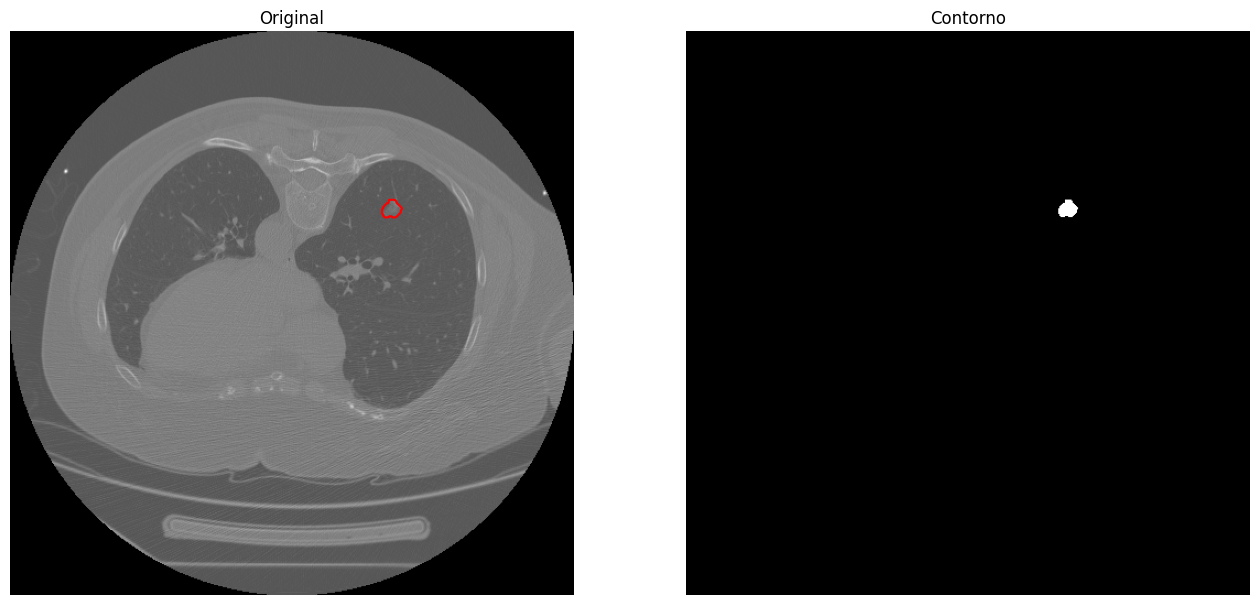

LIDC-IDRI-0939
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


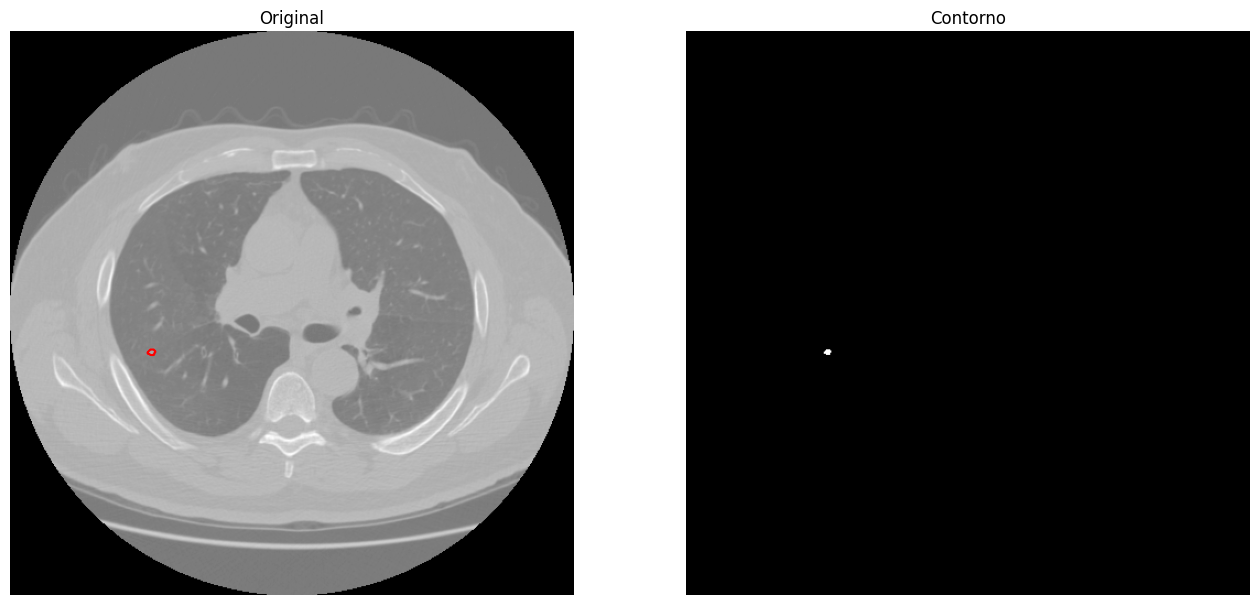

LIDC-IDRI-0940
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


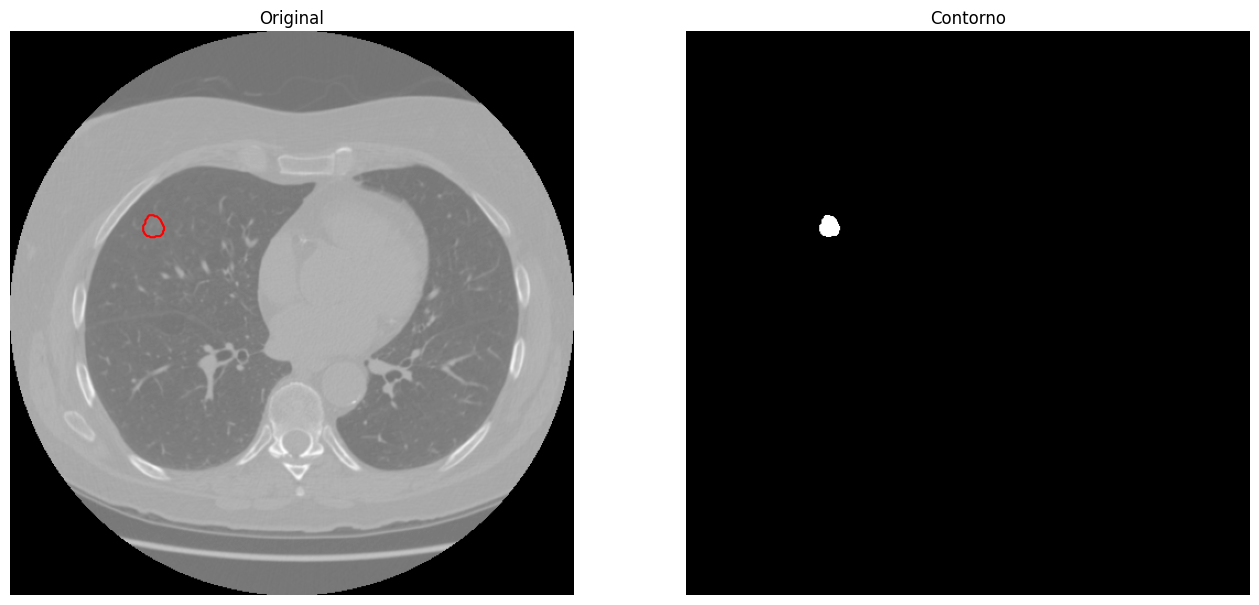

Pacientes n√£o encontrados salvos no arquivo patients_none.txt


In [24]:
params_file = "C:\\Users\\admin\\Desktop\\Laboratorios\\Params.yaml"

deleted_patients = []

dic_list = []

extractor = featureextractor.RadiomicsFeatureExtractor(params_file)


def isolate_nodules(base_masks_dir,folder):
    nodule_id=0
    for i in range(938,941): 
        patient_id = f"LIDC-IDRI-{i:04d}"

        print(patient_id)

        try:
            scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).first()

            if scan is None:
                raise ValueError(f"Scan n√£o encontrado para {patient_id}")

            dicom_files = scan.load_all_dicom_images()

            vec_masks, vol, _ = get_nodule_coordinates(scan, patient_id)
            
            if vec_masks is None or vol is None:
                print(f"N√≥dulo ou volume n√£o encontrado para {patient_id}.")
                continue

            for i in range(len(vec_masks)):
                nodule_id+=1
                
                img_slice, mask_slice, max_slice = isolate_nodule_with_coordinates(vec_masks[i], vol)

                #dicom_file_name = dicom_files[max_slice].SOPInstanceUID

                dicom_file = dicom_files[max_slice]

                # Normalizamos a imagem
                img_slice = normalize_image(img_slice)

                #print(patient_id)
                #print(nodule_id)

                intercept = dicom_file.RescaleIntercept
                slope = dicom_file.RescaleSlope

                # Convertemos para Hounsfield Units
                img_hu = img_slice * slope + intercept

                # Parte da visualiza√ß√£o da m√°scara
                fig, axes = plt.subplots(1, 2, figsize=(16, 8))

                axes[0].imshow(img_hu, cmap='gray')
                axes[0].contour(mask_slice, colors='r')
                axes[0].set_title('Original')
                axes[0].axis('off')

                axes[1].imshow(mask_slice, cmap='gray')
                axes[1].set_title('Contorno')
                axes[1].axis('off')

                plt.show()

                # Convertemos a imagem e a m√°scara para SimpleITK, que √© um formato usado pelo radiomics
                img_sitk = sitk.GetImageFromArray(img_hu.astype(np.float32))
                mask_sitk = sitk.GetImageFromArray(mask_slice.astype(np.uint8))

                #print(img_sitk)
                #print(mask_sitk)

                # Finalmente extra√≠mos as features usando o PyRadiomics
                features = extractor.execute(img_sitk, mask_sitk, label=1)
                dic_list.append(features)

                # Adicionamos PatientID e NoduleID √†s features para poder dar merge com o outro dataset
                features['PatientID'] = patient_id
                features['NoduleID'] = nodule_id

                # Salvamos a m√°scara isolada (opcional)
                #save_mask(mask_slice, patient_id, nodule_id[i], dicom_file_name, base_masks_dir)

        except Exception as e:
            # Se ocorrer um erro (como scan n√£o encontrado), adicionar o paciente √† lista de exclu√≠dos
            print(f"Erro ao processar {patient_id}: {e}")
            deleted_patients.append(patient_id)
            continue

    with open(folder, 'w') as arquivo:
        for element in deleted_patients:
            arquivo.write(element + '\n')
        print(f"Pacientes n√£o encontrados salvos no arquivo {folder}")

base_masks_dir = "C:\\Users\\admin\\Desktop\\Laboratorios\\Masks"
folder = "patients_none.txt"

isolate_nodules(base_masks_dir,folder)

# Criamos o DataFrame a partir das features
features_df = pd.DataFrame(dic_list)

# Salvamos as features extra√≠das em um arquivo excel
output_csv = f"C:/Users/admin/Desktop/Laboratorios/Featurestodas/features_radiomics-TESSSSSSSTE.xlsx"
features_df.to_excel(output_csv, index=False)


<a id="mascaras-3d"></a>
## M√°scaras 3D

[Go back to the top](#indice)

Por fim, nesta parte iremos criar as m√°scaras em 3D para na pr√≥xima fase, podermos discutir alguns resultados obtidos entre o 2D e o 3D. Este c√≥digo √© muito semelhante √† extra√ß√£o de features em 2D. Ao inv√©s de guardarmos a m√°scara da slice de maior √°rea, guardamos a m√°scara total.


In [14]:
def isolate_nodule_3d(consensus_mask_full, vol):
    isolated_nodule_vol = vol * consensus_mask_full
    nodule_slices = np.any(consensus_mask_full, axis=(0, 1))
    
    if not np.any(nodule_slices):
        print("Nenhuma slice cont√©m o n√≥dulo.")
        return None
    
    # Filtra as slices para reduzir a carga
    min_slice, max_slice = np.where(nodule_slices)[0][[0, -1]]
    reduced_nodule_vol = isolated_nodule_vol[:, :, min_slice:max_slice + 1]
    
    return reduced_nodule_vol

Este excerto apenas serve para visualizar a m√°scara criada

In [22]:
def visualize_nodule_3d(nodule_vol):
    if not np.any(nodule_vol):
        print("O volume do n√≥dulo est√° vazio.")
        return
    
    # Reduzir o tamanho da malha para melhorar a performance
    verts, faces, _, _ = measure.marching_cubes(nodule_vol, level=0, step_size=2)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    mesh.set_facecolor([0.3, 0.3, 1, 1])
    ax.add_collection3d(mesh)
    
    x_min, x_max = verts[:, 0].min(), verts[:, 0].max()
    y_min, y_max = verts[:, 1].min(), verts[:, 1].max()
    z_min, z_max = verts[:, 2].min(), verts[:, 2].max()
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    plt.show()

<a id="extracao-das-features"></a>
## Extra√ß√£o das features

[Go back to the top](#indice)

Por fim, √© neste excerto de c√≥digo onde s√£o extra√≠das as features da m√°scara 3D de cada n√≥dulo. Usamos o ficheiro Params3D e guardamos todas as features num csv para podermos estud√°-lo de seguida. Caso queiramos visualizar alguma m√°scara √© so retirar o coment√°rio que chama a fun√ß√£o "visualize_nodule_3d".

Decidimos implementar o 3D para podermos comparar com o uso de 2D e discutir acerca das vantagens e desvantagens destes dois m√©todos.

In [ ]:
params_file_3D = "C:\\Users\\admin\\Desktop\\Laboratorios\\Params3D.yaml"

def extract_radiomics_features(nodule_vol, nodule_mask):
    sitk_vol = sitk.GetImageFromArray(nodule_vol)
    sitk_mask = sitk.GetImageFromArray(nodule_mask.astype(np.uint8))
    
    extractor = featureextractor.RadiomicsFeatureExtractor(params_file_3D)

    result = extractor.execute(sitk_vol, sitk_mask)
    
    return result

def isolate_nodules():
    nodule_id=0
    all_features = []

    for i in range(1, 1013):
        patient_id = f"LIDC-IDRI-{i:04d}"

        try:
            scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).first()
            if scan is None:
                raise ValueError(f"Scan n√£o encontrado para {patient_id}")

            dicom_files = scan.load_all_dicom_images()
            vec_masks, vol, _ = get_nodule_coordinates(scan, patient_id)

            if vec_masks is None or vol is None:
                print(f"N√≥dulo ou volume n√£o encontrado para {patient_id}.")
                continue

            for j in range(len(vec_masks)):
                nodule_id+=1
                
                #visualize_nodule_3d(vec_masks[j])

                features = extract_radiomics_features(vol, vec_masks[j])
                features['NoduleID'] = nodule_id 
                features['PatientID'] = patient_id  

                all_features.append(features)

        except Exception as e:
            print(f"Erro ao processar {patient_id}: {e}")
            continue

    return all_features 



all_features = isolate_nodules()
output_csv = f"C:/Users/admin/Desktop/Laboratorios/radiomics_features_atatasdasfa.xlsx"
features_df = pd.DataFrame(all_features)  
features_df.to_excel(output_csv, index=False)


<a id="pre-processamento-2"></a>
## Pr√© Processamento 2

[Go back to the top](#indice)

Nesta fase iremos come√ßar por analisar o dataset onde se encontram as features extra√≠das

In [ ]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from IPython.display import Image
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier


In [ ]:
'''
import sys
!{sys.executable} -m pip install  xgboost
'''

'\nimport sys\n!{sys.executable} -m pip install  xgboost\n'

Come√ßamos por juntar o dataset criado anteriormente com o dataset criado pelo Pyradiomics, com base no PatientID e no NoduleID

In [ ]:
features_radiomics = pd.read_csv("features_radiomics_todas_TAVEIRA.csv")
nodule_df2 = pd.read_csv("nodule_df.csv")

merged_df = pd.merge(nodule_df2, features_radiomics, on=['PatientID', 'NoduleID'], how='inner')

merged_df.to_csv(r"C:\Users\gjoli\Desktop\UNI3\lab\merged_data.csv", index=False)

print(merged_df.shape)

### Elimina√ß√£o de colunas

Numa primeira abordagem iremos eliminar colunas de vers√µes de bibliotecas e de configura√ß√µes de imagens que s√£o geradas pelo radiomics

columns_to_remove_image_diagnostics = Estas colunas geralmente descrevem propriedades t√©cnicas da imagem, como tamanho, dimensionalidade, e outras caracter√≠sticas que n√£o est√£o diretamente relacionadas √†s caracter√≠sticas radi√¥micas do n√≥dulo.

In [ ]:
columns_to_remove_unecessary_PatientIDs = ['PatientID', 'NoduleID']

columns_to_remove_diagnostics_versions = [
    'diagnostics_Versions_PyRadiomics',
    'diagnostics_Versions_Numpy',
    'diagnostics_Versions_SimpleITK',
    'diagnostics_Versions_PyWavelet',
    'diagnostics_Versions_Python',
]

# Lista de colunas de diagn√≥stico de imagem para remover
'''
columns_to_remove_image_diagnostics = [
    'diagnostics_Configuration_Settings',
    'diagnostics_Configuration_EnabledImageTypes',
    'diagnostics_Image-original_Hash',
    'diagnostics_Image-original_Dimensionality',
    'diagnostics_Image-original_Spacing',
    'diagnostics_Image-original_Size',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_Hash',
    'diagnostics_Mask-original_Spacing',
    'diagnostics_Mask-original_Size',
    'diagnostics_Mask-original_BoundingBox',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum',
    'diagnostics_Mask-original_CenterOfMassIndex',
    'diagnostics_Mask-original_CenterOfMass'
]

'''
merged_df.drop(columns=columns_to_remove_diagnostics_versions, inplace=True)
merged_df.drop(columns=columns_to_remove_unecessary_PatientIDs, inplace=True)

Aqui iremos apagar todas as colunas que t√™m apenas um valor √∫nico na sua totalidade

In [ ]:
# Come√ßamos por calcular o n√∫mero de valores √∫nicos por coluna
valores_unicos = merged_df.nunique()

# Imprimimos o n√∫mero de valores √∫nicos por coluna, ordenado do menor para o maior
print("N√∫mero de valores √∫nicos por coluna (ordenado):")
print(valores_unicos.sort_values(ascending=True))

# Ordenamos o DataFrame pelas colunas com base no n√∫mero de valores √∫nicos
merged_df = merged_df.loc[:, valores_unicos.sort_values(ascending=False).index]

print("DataFrame ordenado por n√∫mero de valores √∫nicos (antes da remo√ß√£o):")

# Por fim removemos as colunas que t√™m apenas um valor √∫nico
merged_df = merged_df.loc[:, merged_df.nunique() > 1]

# Aqui verificamos se algum nao foi eliminado
valores_unicos_final = merged_df.nunique()

print("N√∫mero de valores √∫nicos por coluna no DataFrame final (ordenado):")
print(valores_unicos_final.sort_values(ascending=True))


N√∫mero de valores √∫nicos por coluna (ordenado):
diagnostics_Configuration_EnabledImageTypes             1
diagnostics_Image-original_Size                         1
diagnostics_Image-original_Spacing                      1
diagnostics_Image-original_Dimensionality               1
diagnostics_Mask-original_Spacing                       1
                                                     ... 
original_firstorder_Kurtosis                         2624
original_glszm_LargeAreaLowGrayLevelEmphasis         2624
original_glszm_LowGrayLevelZoneEmphasis              2624
original_firstorder_TotalEnergy                      2624
original_gldm_SmallDependenceLowGrayLevelEmphasis    2624
Length: 121, dtype: int64
DataFrame ordenado por n√∫mero de valores √∫nicos (antes da remo√ß√£o):
N√∫mero de valores √∫nicos por coluna no DataFrame final (ordenado):
InternalStructure                                       4
Margin                                                  5
Lobulation                   

Como vimos acima, n√£o temos qualquer valor bin√°rio que possa criar confus√£o com atributos n√£o bin√°rios

### Tratamento de valores nulos e valores duplicados

Nesta etapa iremos verificar se existem valores nulos ou duplicados e caso hajam iremos remov√™-los

In [ ]:
null_columns = merged_df.isna().sum()
null_columns = null_columns[null_columns > 0]

# Imprime apenas as colunas com valores nulos
print(null_columns)

Series([], dtype: int64)


In [ ]:
print(f'Formato do dataset antes de remover valores duplicados: {merged_df.shape}')
loan_dataset = merged_df.drop_duplicates()
print(f'Formato do dataset depois de remover valores duplicados: {loan_dataset.shape}')

Shape of Loan Dataset before drop duplicated Row is: (2624, 114)
Shape of Loan Dataset After Drop Duplicated Row is: (2624, 114)


### Tratamento de valores n√£o n√∫mericos

Iremos ver se o dataset tem valores que n√£o s√£o numericos, e que portanto necessitem de algum tipo de label Encoder, ou uma especial aten√ß√£o nossa

In [ ]:

# Carregar o DataFrame (substitua pelo seu dataset)
# merged_df = pd.read_csv('merged_data.csv')

# Filtramos as colunas que n√£o t√™m dados do tipo int ou float
non_int_str_columns = merged_df.select_dtypes(exclude=['int', 'float',]).columns
print(non_int_str_columns)




Index(['diagnostics_Mask-original_CenterOfMass',
       'diagnostics_Mask-original_CenterOfMassIndex',
       'diagnostics_Mask-original_Hash',
       'diagnostics_Mask-original_BoundingBox',
       'diagnostics_Image-original_Hash'],
      dtype='object')


Como vimos em cima, podemos come√ßar por remover as colunas 'diagnostics_Mask-original_Hash', 'diagnostics_Image-original_Hash', pois esses atributos representam hashes, que s√£o c√≥digos √∫nicos gerados por uma fun√ß√£o hash. Eles n√£o t√™m significado num√©rico e podem ser removidos

In [ ]:
columns_to_remove = ['diagnostics_Mask-original_Hash', 'diagnostics_Image-original_Hash']
merged_df = merged_df.drop(columns=columns_to_remove)
merged_df = merged_df.drop(columns = 'diagnostics_Mask-original_BoundingBox')

Em rela√ß√£o aos atributos do centro de massa pensamos em agrupar os n√≥dulos com base nessa localiza√ß√£o. A clusteriza√ß√£o ajudar√° a identificar padr√µes de localiza√ß√£o, como a presen√ßa de n√≥dulos em regi√µes espec√≠ficas dos pulm√µes, o que pode estar relacionado com a patologia subjacente. Para isso, o algoritmo K-Means √© uma escolha natural, pois agrupa os pontos em clusters de forma esf√©rica, com base na dist√¢ncia euclidiana

In [ ]:
print(merged_df[['diagnostics_Mask-original_CenterOfMass', 
                 'diagnostics_Mask-original_CenterOfMassIndex', 
                 ]].head())

     diagnostics_Mask-original_CenterOfMass  \
0    (314.9232981783317, 366.0086289549377)   
1   (344.71860986547085, 360.7757847533632)   
2     (368.3704292527822, 347.268680445151)   
3  (366.05067985166875, 352.45117428924596)   
4                        (307.448, 198.072)   

  diagnostics_Mask-original_CenterOfMassIndex  
0      (314.9232981783317, 366.0086289549377)  
1     (344.71860986547085, 360.7757847533632)  
2       (368.3704292527822, 347.268680445151)  
3    (366.05067985166875, 352.45117428924596)  
4                          (307.448, 198.072)  


In [ ]:
import ast

merged_df['diagnostics_Mask-original_CenterOfMass'] = merged_df['diagnostics_Mask-original_CenterOfMass'].apply(ast.literal_eval)
merged_df['diagnostics_Mask-original_CenterOfMassIndex'] = merged_df['diagnostics_Mask-original_CenterOfMassIndex'].apply(ast.literal_eval)

# Combinamos as coordenadas em um √∫nico array para usar na clusteriza√ß√£o
merged_df['x_position'] = merged_df['diagnostics_Mask-original_CenterOfMass'].apply(lambda x: x[0])
merged_df['y_position'] = merged_df['diagnostics_Mask-original_CenterOfMassIndex'].apply(lambda x: x[1])

In [ ]:
from sklearn.cluster import KMeans

# Come√ßamos por preparar os dados para o K-Means
X = merged_df[['x_position', 'y_position']]

kmeans = KMeans(n_clusters=4, random_state=0)

merged_df['Loc_Cluster'] = kmeans.fit_predict(X)

plt.scatter(merged_df['x_position'], merged_df['y_position'], c=merged_df['Loc_Cluster'], cmap='viridis')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Clusteriza√ß√£o dos Centros de Massa dos N√≥dulos')
plt.show()

print(merged_df[['x_position', 'y_position', 'Loc_Cluster']].head())



   x_position  y_position  Loc_Cluster
0  314.923298  366.008629            3
1  344.718610  360.775785            3
2  368.370429  347.268680            3
3  366.050680  352.451174            3
4  307.448000  198.072000            2


In [ ]:
merged_df.drop(columns = ['diagnostics_Mask-original_CenterOfMass', 'diagnostics_Mask-original_CenterOfMassIndex'], inplace = True)


### Tratamento do atributo 'Malignancy'

Iremos agora avan√ßar para a coluna "malignancy" que ser√° a target dos nossos algoritmos e portanto requer maior cuidado

In [ ]:
merged_df["Malignancy"].value_counts()

Malignancy
3    1064
2     644
1     411
4     285
5     220
Name: count, dtype: int64

Grande parte dos estudos relativos a este tema resumiu os valores de Malignancy [1,2,3,4,5] a 2 categorias:

    - Malignancy < 3   -> N√≥dulo Benigno  (0) 
    - Malignancy > 3   -> N√≥dulo Maligno  (1)

E todos os pacientes cuja Malignancy == 3 foram eliminados.

Deste modo, varios relatos indicam que os resultados das classifica√ß√µes s√£o melhores com este agrupamento de Malignancys

'We used the schema suggested by Han et al. [20] and Wei et al. [29], where a lung nodule with a composite malignancy rate 1 or 2 is regarded as benign( 0 ), a rate 4 or 5 is regarded as malignant (1) and a rate of 3 has uncertain malignancy. Nodules rated at 3 can be discarded or regarded as benign or malignant' , as stated Fusing texture, shape and deep model-learned information at decision level for automated classification of lung nodules on chest CT [https://www.sciencedirect.com/science/article/pii/S1566253516301063]



In [ ]:
# Removemos todos os n√≥dulos classificados como 3
merged_df = merged_df[merged_df['Malignancy'] != 3]

# Reclassificamos os valores menores que 3 como 0 e maiores que 3 como 1
merged_df['Malignancy'] = merged_df['Malignancy'].apply(lambda x: 0 if x < 3 else 1)

# Exibimos a contagem dos novos valores da coluna Malignancy
print(merged_df['Malignancy'].value_counts())


Malignancy
0    1055
1     505
Name: count, dtype: int64


### Mudan√ßa de nomes dos atributos

De forma a simplificar o nosso dataset, visto que este tem diversos atributos e muitos deles com nomes bastante extensos iremos proceder √† simplifica√ß√£o dos nomes de alguns atributos

In [ ]:
column_mapping = {
    'InternalStructure': 'Internal_Struct',
    'Sphericity': 'Sphericity',
    'Calcification': 'Calcification',
    'Subtlety': 'Subtlety',
    'Lobulation': 'Lobulation',
    'Margin': 'Margin',
    'Spiculation': 'Spiculation',
    'Texture': 'Texture',
    'Malignancy': 'Malignancy',
    'original_shape2D_Elongation': 'Shape2D_Elongation',
    'original_shape2D_MajorAxisLength': 'Shape2D_MajorAxisLen',
    'original_shape2D_MaximumDiameter': 'Shape2D_MaxDiameter',
    'original_shape2D_MeshSurface': 'Shape2D_MeshSurface',
    'original_shape2D_MinorAxisLength': 'Shape2D_MinorAxisLen',
    'original_shape2D_Perimeter': 'Shape2D_Perimeter',
    'original_shape2D_PerimeterSurfaceRatio': 'Shape2D_PerimeterSurfRatio',
    'original_shape2D_PixelSurface': 'Shape2D_PixelSurface',
    'original_shape2D_Sphericity': 'Shape2D_Sphericity',
    'original_firstorder_10Percentile': 'FirstOrder_10Percentile',
    'original_firstorder_90Percentile': 'FirstOrder_90Percentile',
    'original_firstorder_Energy': 'FirstOrder_Energy',
    'original_firstorder_Entropy': 'FirstOrder_Entropy',
    'original_firstorder_InterquartileRange': 'FirstOrder_IQR',
    'original_firstorder_Kurtosis': 'FirstOrder_Kurtosis',
    'original_firstorder_Maximum': 'FirstOrder_Max',
    'original_firstorder_MeanAbsoluteDeviation': 'FirstOrder_MAD',
    'original_firstorder_Mean': 'FirstOrder_Mean',
    'original_firstorder_Median': 'FirstOrder_Median',
    'original_firstorder_Minimum': 'FirstOrder_Min',
    'original_firstorder_Range': 'FirstOrder_Range',
    'original_firstorder_RobustMeanAbsoluteDeviation': 'FirstOrder_RMAD',
    'original_firstorder_RootMeanSquared': 'FirstOrder_RMS',
    'original_firstorder_Skewness': 'FirstOrder_Skewness',
    'original_firstorder_TotalEnergy': 'FirstOrder_TotalEnergy',
    'original_firstorder_Uniformity': 'FirstOrder_Uniformity',
    'original_firstorder_Variance': 'FirstOrder_Variance',
    'original_glcm_Autocorrelation': 'GLCM_Autocorr',
    'original_glcm_JointAverage': 'GLCM_JointAvg',
    'original_glcm_ClusterProminence': 'GLCM_ClusterProm',
    'original_glcm_ClusterShade': 'GLCM_ClusterShade',
    'original_glcm_ClusterTendency': 'GLCM_ClusterTend',
    'original_glcm_Contrast': 'GLCM_Contrast',
    'original_glcm_Correlation': 'GLCM_Corr',
    'original_glcm_DifferenceAverage': 'GLCM_DiffAvg',
    'original_glcm_DifferenceEntropy': 'GLCM_DiffEntropy',
    'original_glcm_DifferenceVariance': 'GLCM_DiffVariance',
    'original_glcm_JointEnergy': 'GLCM_JointEnergy',
    'original_glcm_JointEntropy': 'GLCM_JointEntropy',
    'original_glcm_Imc1': 'GLCM_IMC1',
    'original_glcm_Imc2': 'GLCM_IMC2',
    'original_glcm_Idm': 'GLCM_IDM',
    'original_glcm_Idmn': 'GLCM_IDMN',
    'original_glcm_Id': 'GLCM_ID',
    'original_glcm_Idn': 'GLCM_IDN',
    'original_glcm_InverseVariance': 'GLCM_InvVariance',
    'original_glcm_MaximumProbability': 'GLCM_MaxProb',
    'original_glcm_SumEntropy': 'GLCM_SumEntropy',
    'original_glcm_SumSquares': 'GLCM_SumSquares',
    'original_glrlm_GrayLevelNonUniformity': 'GLRLM_GrayLevelNonUni',
    'original_glrlm_GrayLevelNonUniformityNormalized': 'GLRLM_GrayLevelNonUniNorm',
    'original_glrlm_GrayLevelVariance': 'GLRLM_GrayLevelVar',
    'original_glrlm_HighGrayLevelRunEmphasis': 'GLRLM_HighGrayRunEmph',
    'original_glrlm_LongRunEmphasis': 'GLRLM_LongRunEmph',
    'original_glrlm_LongRunHighGrayLevelEmphasis': 'GLRLM_LongRunHighGrayEmph',
    'original_glrlm_LongRunLowGrayLevelEmphasis': 'GLRLM_LongRunLowGrayEmph',
    'original_glrlm_LowGrayLevelRunEmphasis': 'GLRLM_LowGrayRunEmph',
    'original_glrlm_RunEntropy': 'GLRLM_RunEntropy',
    'original_glrlm_RunLengthNonUniformity': 'GLRLM_RunLenNonUni',
    'original_glrlm_RunLengthNonUniformityNormalized': 'GLRLM_RunLenNonUniNorm',
    'original_glrlm_RunPercentage': 'GLRLM_RunPerc',
    'original_glrlm_RunVariance': 'GLRLM_RunVar',
    'original_glrlm_ShortRunEmphasis': 'GLRLM_ShortRunEmph',
    'original_glrlm_ShortRunHighGrayLevelEmphasis': 'GLRLM_ShortRunHighGrayEmph',
    'original_glrlm_ShortRunLowGrayLevelEmphasis': 'GLRLM_ShortRunLowGrayEmph',
    'original_glszm_GrayLevelNonUniformity': 'GLSZM_GrayLevelNonUni',
    'original_glszm_GrayLevelNonUniformityNormalized': 'GLSZM_GrayLevelNonUniNorm',
    'original_glszm_GrayLevelVariance': 'GLSZM_GrayLevelVar',
    'original_glszm_HighGrayLevelZoneEmphasis': 'GLSZM_HighGrayZoneEmph',
    'original_glszm_LargeAreaEmphasis': 'GLSZM_LargeAreaEmph',
    'original_glszm_LargeAreaHighGrayLevelEmphasis': 'GLSZM_LargeAreaHighGrayEmph',
    'original_glszm_LargeAreaLowGrayLevelEmphasis': 'GLSZM_LargeAreaLowGrayEmph',
    'original_glszm_LowGrayLevelZoneEmphasis': 'GLSZM_LowGrayZoneEmph',
    'original_glszm_SizeZoneNonUniformity': 'GLSZM_SizeZoneNonUni',
    'original_glszm_SizeZoneNonUniformityNormalized': 'GLSZM_SizeZoneNonUniNorm',
    'original_glszm_SmallAreaEmphasis': 'GLSZM_SmallAreaEmph',
    'original_glszm_SmallAreaHighGrayLevelEmphasis': 'GLSZM_SmallAreaHighGrayEmph',
    'original_glszm_SmallAreaLowGrayLevelEmphasis': 'GLSZM_SmallAreaLowGrayEmph',
    'original_glszm_ZoneEntropy': 'GLSZM_ZoneEntropy',
    'original_glszm_ZonePercentage': 'GLSZM_ZonePerc',
    'original_glszm_ZoneVariance': 'GLSZM_ZoneVar',
    'original_gldm_DependenceEntropy': 'GLDM_DependEntropy',
    'original_gldm_DependenceNonUniformity': 'GLDM_DependNonUni',
    'original_gldm_DependenceNonUniformityNormalized': 'GLDM_DependNonUniNorm',
    'original_gldm_DependenceVariance': 'GLDM_DependVar',
    'original_gldm_GrayLevelNonUniformity': 'GLDM_GrayLevelNonUni',
    'original_gldm_GrayLevelVariance': 'GLDM_GrayLevelVar',
    'original_gldm_HighGrayLevelEmphasis': 'GLDM_HighGrayEmph',
    'original_gldm_LargeDependenceEmphasis': 'GLDM_LargeDependEmph',
    'original_gldm_LargeDependenceHighGrayLevelEmphasis': 'GLDM_LargeDependHighGrayEmph',
    'original_gldm_LargeDependenceLowGrayLevelEmphasis': 'GLDM_LargeDependLowGrayEmph',
    'original_gldm_LowGrayLevelEmphasis': 'GLDM_LowGrayEmph',
    'original_gldm_SmallDependenceEmphasis': 'GLDM_SmallDependEmph',
    'original_gldm_SmallDependenceHighGrayLevelEmphasis': 'GLDM_SmallDependHighGrayEmph',
    'original_gldm_SmallDependenceLowGrayLevelEmphasis': 'GLDM_SmallDependLowGrayEmph'
}

merged_df.rename(columns=column_mapping, inplace=True)
merged_df.columns



Index(['GLDM_SmallDependLowGrayEmph', 'GLSZM_LowGrayZoneEmph', 'GLCM_IDN',
       'FirstOrder_Energy', 'FirstOrder_Kurtosis', 'GLRLM_ShortRunLowGrayEmph',
       'GLCM_IDMN', 'FirstOrder_MAD', 'GLRLM_LongRunLowGrayEmph',
       'GLSZM_LargeAreaLowGrayEmph',
       ...
       'Spiculation', 'Texture', 'Subtlety', 'Sphericity', 'Malignancy',
       'diagnostics_Mask-original_VolumeNum', 'Internal_Struct', 'x_position',
       'y_position', 'Loc_Cluster'],
      dtype='object', length=112)

Claramente o dataset tem demasiados atributos que provavelmente nada acrescentar√£o aos nossos modelos de ML. Com isso em mente, na proxima sec√ß√£o iremos proceder √† sele√ß√£o das features que ser√£o utilizados nos nossos modelos

<a id="feature-selection"></a>
## Feature Selection

[Go back to the top](#indice)

Para a sele√ß√£o das melhores features iremos proceder a v√°rios tipos de m√©todos que consigam medir a relev√¢ncia dos mesmos

###  M√©todos estat√≠sticos


Para identificar as features mais relevantes para o nosso problema, aplicamos dois m√©todos estat√≠sticos de sele√ß√£o de atributos. O primeiro foi a regulariza√ß√£o L1, que utiliza a Regress√£o Log√≠stica com uma penaliza√ß√£o que for√ßa alguns coeficientes a zero. Isso ajuda a eliminar atributos irrelevantes, mantendo apenas aqueles que contribuem para o modelo de forma significativa


Para o uso da Lasso Regression para Features Selection baseamo-nos no estudo 'Feature selection methods and predictive models in CT lung cancer radiomics; Gary Ge 1, Jie Zhang' [https://pmc.ncbi.nlm.nih.gov/articles/PMC9860004/#acm213869-sec-0010] , que afirma:


'Figure 5 shows the distribution of feature selection methods in prognostic studies, which is very similar to that of classification studies. This suggests that the approach to both classification and prognostics studies is quite similar at the feature selection stage. The feature selection method that has become most commonly used in both classification and prognostic studies is LASSO'

In [ ]:
Image(filename=r"C:\Users\gjoli\Desktop\UNI3\lab\ACM2-24-e13869-g005.jpg")

In [ ]:

X = merged_df.drop(columns=['Malignancy'])  # Features
y = merged_df['Malignancy']  # Alvo

# Normalizamos os dados usando o StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividimos em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Valores de C para testar
C_values = [0.05, 0.1, 1.0]

# Listas para armazenar as features selecionadas
selected_features_c0_01 = []
selected_features_c0_1 = []
selected_features_c1_0 = []

# Testamos com cada valor de C
for C in C_values:
    model = LogisticRegression(penalty='l1', solver='liblinear', C=C)
    model.fit(X_train, y_train)

    coef = model.coef_

    # Se coef for uma matriz 2D (problema multiclasse), use apenas os coeficientes da primeira classe
    if coef.ndim > 1:
        coef = coef[0]

    # Selecionamos as features com coeficientes diferentes de zero
    selected_features = X.columns[(coef != 0).ravel()]

    if C == 0.05:
        selected_features_L1_005 = selected_features
    elif C == 0.1:
        selected_features_L1_01 = selected_features
    elif C == 1.0:
        selected_features_L1_1 = selected_features

# Por fim imprimimos as features selecionadas para cada valor de C
print("Selected features after L1 Regularization for C=0.01:", selected_features_L1_005)
print("Selected features after L1 Regularization for C=0.1:", selected_features_L1_01)
print("Selected features after L1 Regularization for C=1.0:", selected_features_L1_1)




Selected features after L1 Regularization for C=0.01: Index(['GLCM_IMC1', 'Shape2D_MinorAxisLen', 'Shape2D_MajorAxisLen',
       'GLCM_JointEntropy', 'Shape2D_PerimeterSurfRatio', 'Shape2D_Sphericity',
       'GLDM_DependVar', 'FirstOrder_Min', 'Calcification', 'Margin',
       'Lobulation', 'Spiculation', 'Texture', 'Subtlety', 'Internal_Struct'],
      dtype='object')
Selected features after L1 Regularization for C=0.1: Index(['FirstOrder_Skewness', 'GLCM_ClusterProm', 'GLCM_ClusterShade',
       'GLCM_IMC1', 'Shape2D_MinorAxisLen', 'Shape2D_MajorAxisLen',
       'GLCM_JointEntropy', 'Shape2D_Sphericity', 'GLSZM_ZoneVar',
       'GLRLM_RunVar', 'GLDM_DependVar', 'FirstOrder_Min',
       'diagnostics_Image-original_Minimum', 'Calcification', 'Margin',
       'Lobulation', 'Spiculation', 'Texture', 'Subtlety', 'Internal_Struct'],
      dtype='object')
Selected features after L1 Regularization for C=1.0: Index(['FirstOrder_Energy', 'FirstOrder_Kurtosis', 'GLCM_IDMN',
       'GLRLM_LongR

### M√©todos Baseados em Modelos

#### RANDOM FOREST CLASSIFIER

O mesmo estudo citado para o Lasso regression menciona a grande populariedade do algoritmo do Random Forest para a sele√ß√£o de features radiomicos, e portanto decidimos tamb√©m usar esse algoritmo para selecionar features

In [ ]:

# Definimos as vari√°veis independentes (X) e dependentes (y)
X = merged_df.drop(columns=['Malignancy']) 
y = merged_df['Malignancy'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Import√¢ncia das features
importances = rf_model.feature_importances_

# Criamos um DataFrame para visualizar as import√¢ncias
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Ordenamos o DataFrame pela import√¢ncia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(30, 120))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Import√¢ncia das Features - Random Forest', fontsize=16)
plt.show()

# Selecionar as top N features (por exemplo, as 10 mais importantes)
combined_features_tree = feature_importances.head(20)['Feature'].tolist()
print("Top N Features selecionadas:", combined_features_tree)



Top N Features selecionadas: ['Shape2D_Perimeter', 'Shape2D_MinorAxisLen', 'diagnostics_Mask-original_VoxelNum', 'Shape2D_PixelSurface', 'Shape2D_PerimeterSurfRatio', 'Shape2D_MaxDiameter', 'GLRLM_GrayLevelNonUni', 'Shape2D_MajorAxisLen', 'GLDM_DependNonUni', 'GLSZM_GrayLevelNonUni', 'GLRLM_RunLenNonUni', 'GLSZM_SizeZoneNonUni', 'Calcification', 'Shape2D_MeshSurface', 'GLDM_GrayLevelNonUni', 'GLDM_SmallDependLowGrayEmph', 'GLCM_IDN', 'FirstOrder_Mean', 'FirstOrder_10Percentile', 'FirstOrder_90Percentile']


### Wrapper Methods

#### RFE Method


RFE (Recursive Feature Elimination) √© uma t√©cnica de sele√ß√£o de atributos que faz parte dos chamados wrapper methods. Funciona iterativamente, eliminando os atributos menos importantes do modelo a cada etapa, at√© que o n√∫mero desejado de atributos seja alcan√ßado.

In [ ]:
model = LogisticRegression(max_iter=1000)

# Diferentes valores de n para as features
n_features_list = [10, 15, 20]

selected_features_rfe_10 = []
selected_features_rfe_15 = []
selected_features_rfe_20 = []

for n_features in n_features_list:
    rfe = RFE(model, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    
    selected_features = X.columns[rfe.support_].tolist()
    
    # Para cada valor guarda o numero de atributos
    if n_features == 10:
        selected_features_rfe_10 = selected_features
    elif n_features == 15:
        selected_features_rfe_15 = selected_features
    elif n_features == 20:
        selected_features_rfe_20 = selected_features

print("Selected features with RFE (n_features_to_select=5):", selected_features_rfe_10)
print("Selected features with RFE (n_features_to_select=10):", selected_features_rfe_15)
print("Selected features with RFE (n_features_to_select=15):", selected_features_rfe_20)



c:\Users\gjoli\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\gjoli\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

Selected features with RFE (n_features_to_select=5): ['GLCM_Corr', 'GLCM_SumEntropy', 'GLCM_JointEntropy', 'Shape2D_Sphericity', 'GLRLM_RunVar', 'GLDM_LargeDependEmph', 'GLRLM_LongRunEmph', 'Calcification', 'Subtlety', 'Internal_Struct']
Selected features with RFE (n_features_to_select=10): ['GLCM_Corr', 'GLCM_InvVariance', 'GLDM_DependEntropy', 'GLCM_SumEntropy', 'GLCM_JointEntropy', 'Shape2D_Sphericity', 'GLSZM_ZoneVar', 'GLRLM_RunVar', 'GLDM_LargeDependEmph', 'GLRLM_LongRunEmph', 'Calcification', 'Spiculation', 'Texture', 'Subtlety', 'Internal_Struct']
Selected features with RFE (n_features_to_select=15): ['GLCM_IDM', 'GLCM_Corr', 'GLCM_InvVariance', 'GLCM_ID', 'Shape2D_Elongation', 'GLDM_DependEntropy', 'GLCM_SumEntropy', 'GLCM_JointEntropy', 'Shape2D_Sphericity', 'GLSZM_ZoneVar', 'GLRLM_RunVar', 'GLRLM_RunLenNonUniNorm', 'GLDM_LargeDependEmph', 'GLSZM_LargeAreaEmph', 'GLRLM_LongRunEmph', 'Calcification', 'Spiculation', 'Texture', 'Subtlety', 'Internal_Struct']


### Correla√ß√£o

Podemos tamb√©m ver quais s√£o os atributos com maior correla√ß√£o com o atributo 'Malignancy' e observar que cada atributo cuja correla√ß√£o est√° acima do treshold  est√° contido em pelo menos numa das listas para cada algoritmo de sele√ß√£o de features

Top 15 features with highest correlation to Malignancy:
Index(['Malignancy', 'Shape2D_MinorAxisLen', 'Shape2D_MajorAxisLen',
       'Shape2D_MaxDiameter', 'Shape2D_Perimeter',
       'Shape2D_PerimeterSurfRatio', 'GLCM_IMC1', 'Shape2D_PixelSurface',
       'diagnostics_Mask-original_VoxelNum', 'Shape2D_MeshSurface',
       'GLRLM_RunLenNonUni', 'GLSZM_SizeZoneNonUni', 'GLDM_DependNonUni',
       'GLCM_IDN', 'GLDM_DependVar'],
      dtype='object')


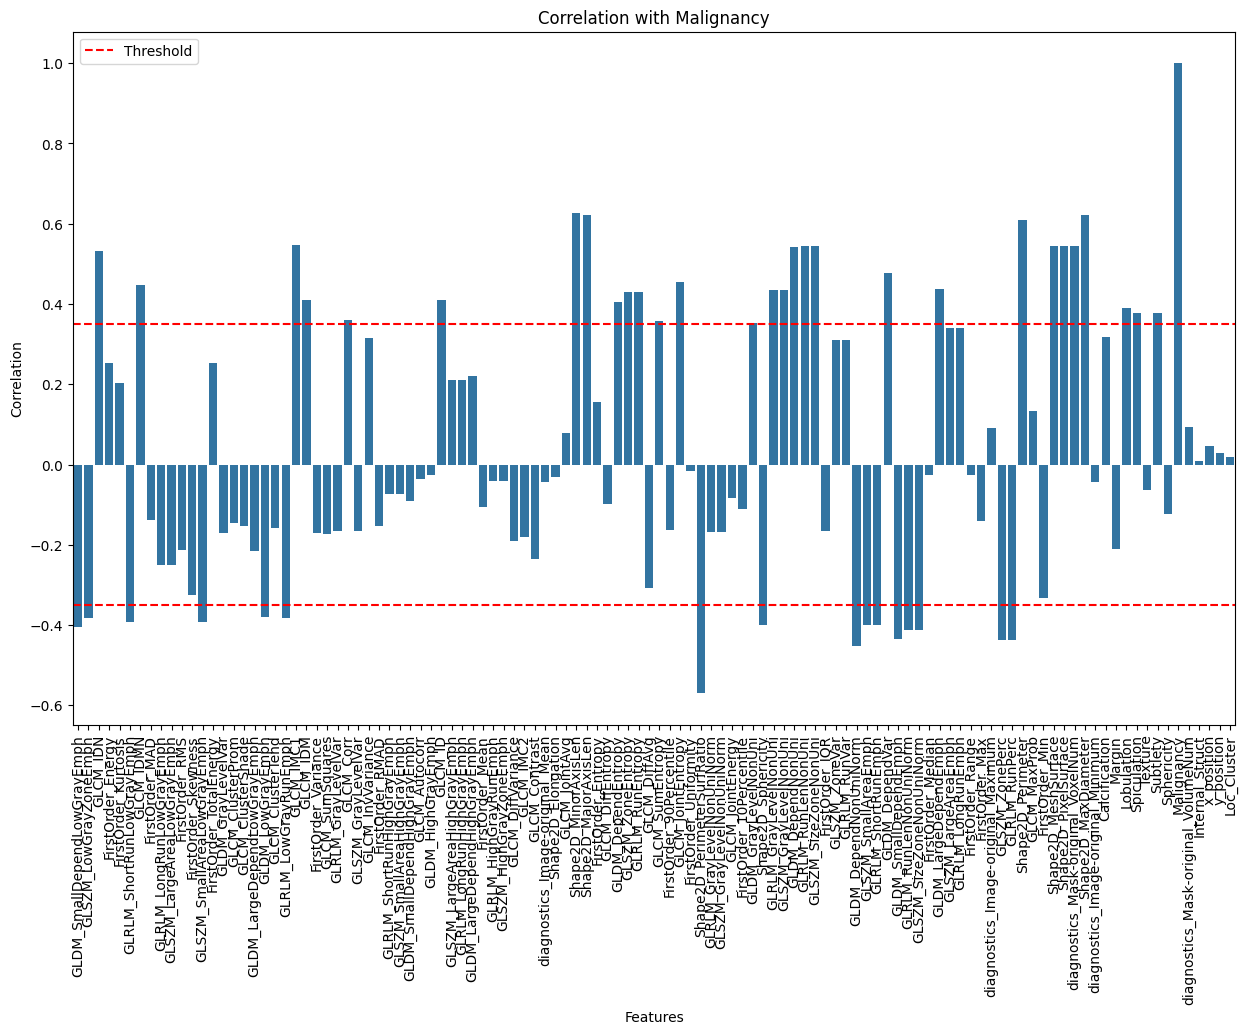

In [ ]:

# Definimos o threshold para a correla√ß√£o
correlation_threshold = 0.35

# Calculamos a correla√ß√£o de cada features em rela√ß√£o ao atributo 'Malignancy' 
correlation_with_malignancy = merged_df.corr()['Malignancy']

high_correlation_features = correlation_with_malignancy[correlation_with_malignancy.abs() >= correlation_threshold]

# Obtemos as 15 features com correla√ß√£o mais alta
high_correlation_features = high_correlation_features.abs().nlargest(15).index

print("Top 15 features:")
print(high_correlation_features)

plt.figure(figsize=(15, 9))
sns.barplot(x=correlation_with_malignancy.index, y=correlation_with_malignancy)
plt.xticks(rotation=90)
plt.title('Correla√ß√£o com Malignancy')
plt.xlabel('Features')
plt.ylabel('Correla√ß√£o')
plt.axhline(y=correlation_threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(y=-correlation_threshold, color='r', linestyle='--')
plt.legend()
plt.show()


Ap√≥s estas altera√ß√µes acima descritas ficamos com estes conjuntos de features.

selected_features_L1_005, selected_features_L1_01, selected_features_L1_1,
combined_features_tree, selected_features_rfe_10, selected_features_rfe_15, selected_features_rfe_20, high_correlation_features

# ISTO √â PRECISO?????

In [ ]:
'''

# Garantir que todas as vari√°veis sejam listas antes de combinar
selected_features_L1_005 = list(selected_features_L1_005)
selected_features_L1_01 = list(selected_features_L1_01)
selected_features_L1_1 = list(selected_features_L1_1)
selected_features_ANOVA_k5 = list(selected_features_ANOVA_k5)
selected_features_ANOVA_k10 = list(selected_features_ANOVA_k10)
selected_features_ANOVA_k15 = list(selected_features_ANOVA_k15)
combined_features_tree = list(combined_features_tree)
selected_features_rfe_10 = list(selected_features_rfe_10)
selected_features_rfe_15 = list(selected_features_rfe_15)
selected_features_rfe_20 = list(selected_features_rfe_20)
high_correlation_features = list(high_correlation_features)

# Combinar todas as listas em um conjunto de atributos √∫nicos
all_selected_features = set(
    selected_features_L1_005 + selected_features_L1_01 + selected_features_L1_1 + 
    selected_features_ANOVA_k5 + selected_features_ANOVA_k10 + selected_features_ANOVA_k15 +
    combined_features_tree + selected_features_rfe_10 + selected_features_rfe_15 + 
    selected_features_rfe_20 + high_correlation_features
)
print(all_selected_features)

'''

'\n\n# Garantir que todas as vari√°veis sejam listas antes de combinar\nselected_features_L1_005 = list(selected_features_L1_005)\nselected_features_L1_01 = list(selected_features_L1_01)\nselected_features_L1_1 = list(selected_features_L1_1)\nselected_features_ANOVA_k5 = list(selected_features_ANOVA_k5)\nselected_features_ANOVA_k10 = list(selected_features_ANOVA_k10)\nselected_features_ANOVA_k15 = list(selected_features_ANOVA_k15)\ncombined_features_tree = list(combined_features_tree)\nselected_features_rfe_10 = list(selected_features_rfe_10)\nselected_features_rfe_15 = list(selected_features_rfe_15)\nselected_features_rfe_20 = list(selected_features_rfe_20)\nhigh_correlation_features = list(high_correlation_features)\n\n# Combinar todas as listas em um conjunto de atributos √∫nicos\nall_selected_features = set(\n    selected_features_L1_005 + selected_features_L1_01 + selected_features_L1_1 + \n    selected_features_ANOVA_k5 + selected_features_ANOVA_k10 + selected_features_ANOVA_k15 

<a id="modelos-ml"></a>
## MODELOS ML (MAIS PARA ESCREVER AQUI)

[Go back to the top](#indice)

Ap√≥s o pr√© processamento e a sele√ß√£o de features podemos avan√ßar para o desenvolvimento dos modelos Machine Learning.

In [ ]:
feature_sets = {
    'L1_005': selected_features_L1_005,
    'L1_01': selected_features_L1_01,
    'L1_1': selected_features_L1_1,
    #'ANOVA_k5': selected_features_ANOVA_k5,
    #'ANOVA_k10': selected_features_ANOVA_k10,
    #'ANOVA_k15': selected_features_ANOVA_k15,
    'Combined_Tree': combined_features_tree,
    'RFE_10': selected_features_rfe_10,
    'RFE_15': selected_features_rfe_15,
    'RFE_20': selected_features_rfe_20,
    
}

As m√©tricas usadas para avaliar foram a accuracy, a precision, recall, f1 score e AUC-ROC.

In [ ]:

def calculate_metrics(y_true, y_pred, y_prob):
    # Calcular as m√©tricas de precis√£o, recall e f1
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Verifique se y_prob √© 2D e obtenha as probabilidades corretas
    if len(y_prob.shape) > 1:
        y_prob = y_prob[:, 1]  # Pega as probabilidades da classe positiva
    
    # Calcular AUC-ROC
    roc_auc = roc_auc_score(y_true, y_prob)  # Para o caso bin√°rio

    return accuracy, precision, recall, f1, roc_auc


def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)  # Probabilidades para AUC-ROC
    return y_pred, y_prob


def run_experiment(feature_sets, merged_df, model):
    metrics_list = []

    for feature_set_name, features in feature_sets.items():
        X = merged_df[features]
        y = merged_df['Malignancy'].values.flatten()
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        y_pred, y_prob = train_and_evaluate_model(model, X_train, X_test, y_train, y_test)

        accuracy, precision, recall, f1, roc_auc = calculate_metrics(y_test, y_pred, y_prob)
        
        metrics_list.append({
            'Feature_Set': feature_set_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC-ROC': roc_auc
        })
    
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df.sort_values(by='AUC-ROC', ascending=False, inplace=True)  # Decidimos ordenar pelos melhores resultados de AUC-ROC
    return metrics_df



### RANDOM FOREST

O primeiro algoritmo de classifica√ß√£o que usaremos ser√° o algoritmo Random Forest. Esta decis√£o foi baseado no seguinte estudo, onde este obteve excelentes resultados.

Enhanced lung cancer detection: Integrating improved random walker segmentation with artificial neural network and random forest classifier
Sneha S. Nair a, V.N. Meena Devi a, Saju Bhasi b [https://www.sciencedirect.com/science/article/pii/S2405844024050631]

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

metrics_RF_df = run_experiment(feature_sets, merged_df, rf_model)

print(metrics_RF_df)

     Feature_Set  Accuracy  Precision    Recall  F1-Score   AUC-ROC
1          L1_01  0.878205   0.927711  0.706422  0.802083  0.936300
0         L1_005  0.875000   0.906977  0.715596  0.800000  0.936096
2           L1_1  0.871795   0.925926  0.688073  0.789474  0.926899
5         RFE_15  0.858974   0.865169  0.706422  0.777778  0.913386
3  Combined_Tree  0.855769   0.872093  0.688073  0.769231  0.911918
6         RFE_20  0.858974   0.873563  0.697248  0.775510  0.909680
4         RFE_10  0.858974   0.873563  0.697248  0.775510  0.891377


### XGBoost

De seguida iremos utilizar o algoritmo XGBoost, onde os par√¢metros usados foram baseados no estudo de Nasiri e Hasani, intitulado "Automated detection of COVID-19 cases from chest X-ray images using deep neural network and XGBoost" (2021) [https://arxiv.org/abs/2109.02428].

Nesse estudo, os autores combinaram redes neurais profundas para extra√ß√£o de caracter√≠sticas de imagens de raio-X de t√≥rax com o algoritmo XGBoost para realizar a classifica√ß√£o. O uso do XGBoost foi fundamental para atingir uma excelente performance de classifica√ß√£o, aproveitando a sua capacidade de modelar dados complexos e capturar intera√ß√µes n√£o lineares nas caracter√≠sticas extra√≠das.

Os resultados obtidos com esta abordagem foram igualmente excelentes o que demonstram a efic√°cia do XGBoost em capturar padr√µes complexos em imagens m√©dicas.

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=100,         
    learning_rate=0.44,
    gamma=0,                  # Lagrange multiplier
    max_depth=6,              # Profundidade m√°xima das √°rvores
    random_state=42,          
    use_label_encoder=False,  # Evitar warnings relacionados ao label encoder
    eval_metric='mlogloss'    # Fun√ß√£o de avalia√ß√£o
)

metrics_XGB_df = run_experiment(feature_sets, merged_df, xgb_model)

print(metrics_XGB_df)





c:\Users\gjoli\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\gjoli\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\gjoli\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\gjoli\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:23

     Feature_Set  Accuracy  Precision    Recall  F1-Score   AUC-ROC
2           L1_1  0.897436   0.942529  0.752294  0.836735  0.945677
0         L1_005  0.887821   0.911111  0.752294  0.824121  0.940164
1          L1_01  0.871795   0.887640  0.724771  0.797980  0.938853
3  Combined_Tree  0.852564   0.870588  0.678899  0.762887  0.919510
5         RFE_15  0.862179   0.875000  0.706422  0.781726  0.913454
6         RFE_20  0.839744   0.839080  0.669725  0.744898  0.905907
4         RFE_10  0.855769   0.847826  0.715596  0.776119  0.901478


### Resultados obtidos (Acho que ali n√£o √© TP mas sim FN)

Iremos agora real√ßar os 3 melhores conjuntos de atributos para cada algoritmo usado.

- Para o algoritmo de Random forest os 3 conjuntos de atributos que obtiveram melhores resultados foram:
                - L1_1
                - L1_01
                - L1_005
- Para o algoritmo de XGB os 3 conjuntos de atributos que obtiveram melhores resultados foram:
                - L1_1
                - L1_01
                - L1_005


De forma a tentar melhorar a performance destes algoritmos iremos verificar se a nossa classe apresenta algum problema de desbalanceamento.

IREMOS AGORA TENTAR MELHORAR A PERFORMANCE DOS 3 ALGORITMOS UTILIZANDO APENAS O CONJUNTO DE FEATURES SELECIONADOS, E VER COMO EST√ÉO OS TP( PESSOAL QUE TEM CANCRO MAS QUE FOI CLASSIFICADO COMO BENIGNO)



In [ ]:
merged_df["Malignancy"].value_counts()

Malignancy
0    1055
1     505
Name: count, dtype: int64

Atrav√©s da an√°lise dos dados, podemos ver que estes est√£o desbalanceados. Para combater isso iremos usar SMOTE que cria exemplos sint√©ticos da classe em menor n√∫mero.

Os valores de ùëò e random state foram adotados com base no estudo de Yuting Yang e Golrokh Mirzaei, 

'Yang, Y., & Mirzaei, G. Performance analysis of data resampling on class imbalance and classification techniques  for cancer classification' [https://pmc.ncbi.nlm.nih.gov/articles/PMC10903850/#sec002]

que analisou a efic√°cia do SMOTE em contextos de desbalanceamento de classes em problemas de classifica√ß√£o de cancro do pulm√£o.







In [ ]:
from imblearn.over_sampling import SMOTE

X = merged_df.drop('Malignancy', axis=1)
y = merged_df['Malignancy']

smote = SMOTE(random_state=42, k_neighbors=5)
X_bal, y_bal = smote.fit_resample(X, y)

merged_df = pd.concat([pd.DataFrame(X_bal, columns=X.columns), pd.DataFrame(y_bal, columns=['Malignancy'])], axis=1)

print("Distribui√ß√£o de classes ap√≥s SMOTE:")
print(merged_df['Malignancy'].value_counts())


Distribui√ß√£o de classes ap√≥s SMOTE:
Malignancy
1    1055
0    1055
Name: count, dtype: int64


Utilizaremos agora o teste de Shapiro-Wilk apenas em atributos do tipo float, pois esse teste √© adequado para dados cont√≠nuos e permite avaliar a normalidade, que √© crucial para v√°rias t√©cnicas estat√≠sticas e algoritmos de machine learning.  A normaliza√ß√£o por Z-Score foi aplicada a atributos que n√£o apresentaram distribui√ß√£o normal uma vez que, essa t√©cnica facilita a compara√ß√£o entre caracter√≠sticas em escalas diferentes e melhora a performance de modelos que s√£o sens√≠veis a essas diferen√ßas, garantindo que cada atributo contribua de forma equitativa para a an√°lise.

In [ ]:
from scipy.stats import shapiro

float_columns = merged_df.select_dtypes(include=['float64']).columns

columns_to_normalize = []

for col in float_columns:
    stat, p_value = shapiro(merged_df[col])
    print(f'Teste Shapiro-Wilk para {col}: Estat√≠stica={stat:.3f}, p-value={p_value:.3f}')
    
    # Verificar se o p-value √© menor que 0.05
    if p_value < 0.05:
        print(f'O atributo {col} n√£o √© normalmente distribu√≠do.')
        columns_to_normalize.append(col)
    else:
        print(f'O atributo {col} √© normalmente distribu√≠do.')


if columns_to_normalize:
    scaler = StandardScaler()
    merged_df[columns_to_normalize] = scaler.fit_transform(merged_df[columns_to_normalize])
    print(f'A normaliza√ß√£o Z-Score foi aplicada √†s colunas: {columns_to_normalize}')
else:
    print('Nenhuma coluna necessitou de normaliza√ß√£o.')


Teste Shapiro-Wilk para GLDM_SmallDependLowGrayEmph: Estat√≠stica=0.755, p-value=0.000
O atributo GLDM_SmallDependLowGrayEmph n√£o √© normalmente distribu√≠do.
Teste Shapiro-Wilk para GLSZM_LowGrayZoneEmph: Estat√≠stica=0.745, p-value=0.000
O atributo GLSZM_LowGrayZoneEmph n√£o √© normalmente distribu√≠do.
Teste Shapiro-Wilk para GLCM_IDN: Estat√≠stica=0.959, p-value=0.000
O atributo GLCM_IDN n√£o √© normalmente distribu√≠do.
Teste Shapiro-Wilk para FirstOrder_Energy: Estat√≠stica=0.506, p-value=0.000
O atributo FirstOrder_Energy n√£o √© normalmente distribu√≠do.
Teste Shapiro-Wilk para FirstOrder_Kurtosis: Estat√≠stica=0.492, p-value=0.000
O atributo FirstOrder_Kurtosis n√£o √© normalmente distribu√≠do.
Teste Shapiro-Wilk para GLRLM_ShortRunLowGrayEmph: Estat√≠stica=0.746, p-value=0.000
O atributo GLRLM_ShortRunLowGrayEmph n√£o √© normalmente distribu√≠do.
Teste Shapiro-Wilk para GLCM_IDMN: Estat√≠stica=0.833, p-value=0.000
O atributo GLCM_IDMN n√£o √© normalmente distribu√≠do.
Teste 

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

metrics_RF_processed_df = run_experiment(feature_sets, merged_df, rf_model)

print(metrics_RF_processed_df)

     Feature_Set  Accuracy  Precision    Recall  F1-Score   AUC-ROC
1          L1_01  0.879147   0.861386  0.883249  0.872180  0.955307
0         L1_005  0.872038   0.848780  0.883249  0.865672  0.953187
2           L1_1  0.872038   0.852217  0.878173  0.865000  0.952781
5         RFE_15  0.874408   0.860000  0.873096  0.866499  0.947986
6         RFE_20  0.876777   0.868020  0.868020  0.868020  0.946644
4         RFE_10  0.886256   0.870647  0.888325  0.879397  0.943689
3  Combined_Tree  0.862559   0.839024  0.873096  0.855721  0.937191


In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=100,         
    learning_rate=0.44,       
    gamma=0,                  
    max_depth=6,              
    random_state=42,          
    use_label_encoder=False,  
    eval_metric='mlogloss'    
)

metrics_XGB_processed_df = run_experiment(feature_sets, merged_df, xgb_model)

print(metrics_XGB_processed_df)


c:\Users\gjoli\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\gjoli\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\gjoli\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\gjoli\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:24

     Feature_Set  Accuracy  Precision    Recall  F1-Score   AUC-ROC
2           L1_1  0.900474   0.870813  0.923858  0.896552  0.970310
1          L1_01  0.909953   0.873239  0.944162  0.907317  0.965595
0         L1_005  0.886256   0.863415  0.898477  0.880597  0.958331
6         RFE_20  0.883886   0.866337  0.888325  0.877193  0.952690
5         RFE_15  0.874408   0.846154  0.893401  0.869136  0.946148
4         RFE_10  0.872038   0.845411  0.888325  0.866337  0.939583
3  Combined_Tree  0.855450   0.820755  0.883249  0.850856  0.924467


Ap√≥s os resultados obtidos, iremos visualizar se houve, ou n√£o, melhoramentos nos nossos modelos, e provar esses melhoramentos estatisticamente.

In [ ]:
from scipy import stats

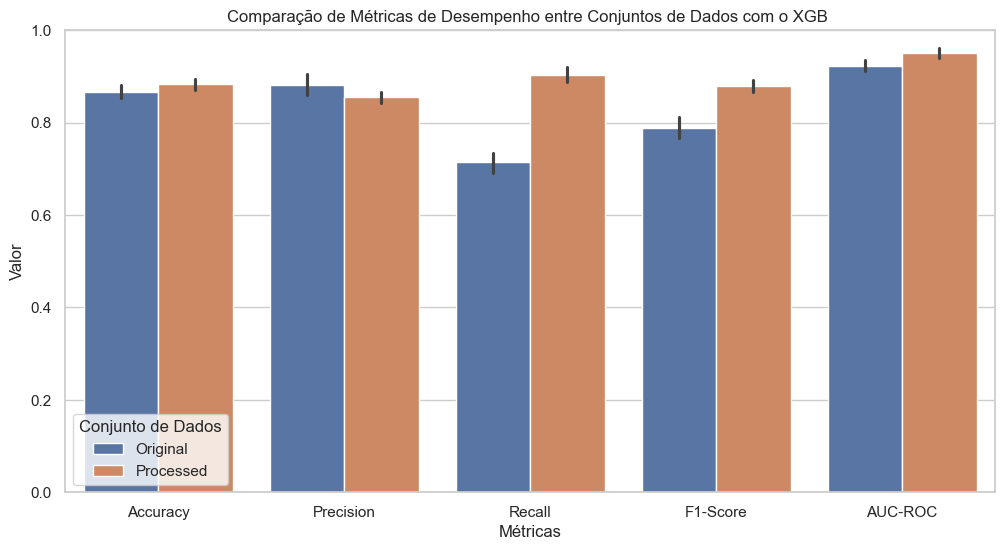

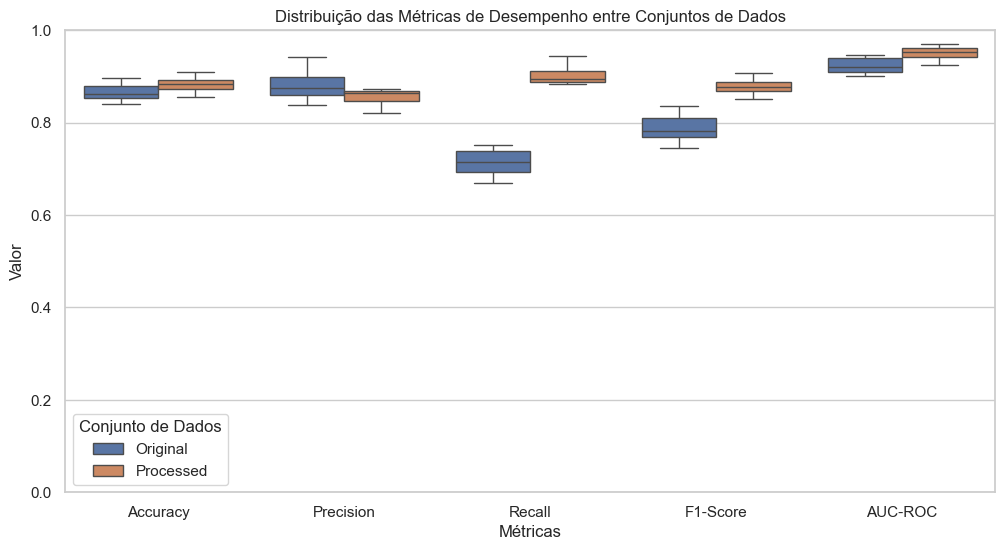

In [ ]:
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


metrics_combined = pd.concat([
    metrics_XGB_df.assign(Dataset='Original'),
    metrics_XGB_processed_df.assign(Dataset='Processed')
], ignore_index=True)


metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']


sns.set(style='whitegrid')


plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=metrics_combined.melt(id_vars='Dataset', value_vars=metrics_to_plot), 
                        x='variable', y='value', hue='Dataset')
plt.title('Compara√ß√£o de M√©tricas de Desempenho entre Conjuntos de Dados com o XGB ')
plt.xlabel('M√©tricas')
plt.ylabel('Valor')
plt.legend(title='Conjunto de Dados')
plt.ylim(0, 1)  # Podemos ajustar aqui o intervalo das m√©tricas
plt.show()

plt.figure(figsize=(12, 6))
box_plot = sns.boxplot(data=metrics_combined.melt(id_vars='Dataset', value_vars=metrics_to_plot), 
                        x='variable', y='value', hue='Dataset')
plt.title('Distribui√ß√£o das M√©tricas de Desempenho entre Conjuntos de Dados')
plt.xlabel('M√©tricas')
plt.ylabel('Valor')
plt.legend(title='Conjunto de Dados')
plt.ylim(0, 1) 
plt.show()


<a id="discussao-dos-resultados-1"></a>
## Discuss√£o dos resultados 1

[Go back to the top](#indice)

-Accuracy: O conjunto "Processed" apresenta uma ligeira melhoria em rela√ß√£o ao conjunto "Original". No entanto, a diferen√ßa n√£o √© muito grande, indicando que o processamento dos dados trouxe uma leve melhoria na capacidade geral de classifica√ß√£o.

-Precision: O conjunto "Original" possui um valor de precis√£o mais alto que o "Processed". A precis√£o refere-se √† propor√ß√£o de verdadeiros positivos (diagn√≥sticos corretos de presen√ßa de doen√ßa) em rela√ß√£o a todos os diagn√≥sticos positivos (verdadeiros positivos + falsos positivos). Uma diminui√ß√£o na precis√£o sugere um ligeiro aumento nos falsos positivos, mas n√£o necessariamente indica uma aumento nos falsos negativos (o que √© positivo, pois um falso negativo em contexto m√©dico ser√° mais grave para o paciente)

Recall: Essa m√©trica mostra a maior diferen√ßa entre os dois conjuntos. O recall √© crucial no contexto m√©dico, pois mede a propor√ß√£o de casos verdadeiramente positivos que o modelo conseguiu identificar. O aumento significativo no recall no conjunto "Processed" indica que o pr√©-processamento dos dados ajudou a reduzir o n√∫mero de falsos negativos, que, em diagn√≥sticos m√©dicos, s√£o os mais cr√≠ticos, pois representam casos em que uma condi√ß√£o (como uma doen√ßa) est√° presente, mas o modelo n√£o a identifica. Reduzir falsos negativos significa que mais pacientes que realmente t√™m a condi√ß√£o ser√£o identificados e tratados.

F1-Score: Este valor representa uma m√©dia harm√¥nica entre precis√£o e recall. A melhoria no F1-Score para o conjunto "Processed" reflete que tanto a precis√£o quanto o recall melhoraram, o que indica um modelo mais equilibrado. No contexto de sa√∫de, isso √© importante, pois o F1-Score ajuda a avaliar o desempenho em condi√ß√µes onde tanto a identifica√ß√£o correta (recall) quanto a minimiza√ß√£o de alarmes falsos (precision) s√£o importantes.

AUC-ROC: A √°rea sob a curva ROC avalia a capacidade do modelo em distinguir entre classes. Com um valor muito pr√≥ximo de 1.0 para o conjunto "Processed", essa m√©trica indica que o modelo consegue separar muito bem os casos positivos dos negativos, o que √© essencial em classifica√ß√µes de alto risco, como diagn√≥sticos de doen√ßas.


> Implica√ß√µes dos Falsos Negativos

Em um contexto m√©dico, como diagn√≥sticos de doen√ßas, falsos negativos s√£o extremamente graves, pois representam casos em que o modelo falha em detectar a condi√ß√£o real de um paciente. Pacientes que recebem falsos negativos podem n√£o receber o tratamento necess√°rio, o que pode resultar na progress√£o da doen√ßa. A melhoria observada no recall para o conjunto "Processed" sugere que o n√∫mero de falsos negativos foi reduzido, o que representa um avan√ßo significativo na seguran√ßa e efic√°cia do modelo no diagn√≥stico.

In [ ]:
results = []

for metric in metrics_to_plot:
    original_data = metrics_combined.loc[metrics_combined['Dataset'] == 'Original', metric]
    processed_data = metrics_combined.loc[metrics_combined['Dataset'] == 'Processed', metric]

    # Teste de Normalidade
    stat, p_value = stats.shapiro(original_data)
    is_normal_original = p_value > 0.05

    stat, p_value = stats.shapiro(processed_data)
    is_normal_processed = p_value > 0.05

    # Escolher o teste apropriado
    if is_normal_original and is_normal_processed:
        # Teste t de Student
        t_stat, p_value = stats.ttest_ind(original_data, processed_data)
        test_name = 'T-test'
    else:
        # Teste de Mann-Whitney
        u_stat, p_value = stats.mannwhitneyu(original_data, processed_data)
        test_name = 'Mann-Whitney U-test'

    results.append({
        'Metric': metric,
        'Test': test_name,
        'p-value': p_value
    })

results_df = pd.DataFrame(results)

print(results_df)

      Metric    Test       p-value
0   Accuracy  T-test  1.371344e-01
1  Precision  T-test  1.056419e-01
2     Recall  T-test  2.734743e-08
3   F1-Score  T-test  4.418180e-05
4    AUC-ROC  T-test  1.023109e-02


<a id="discussao-dos-resultados-2"></a>
## Discuss√£o dos resultados 2

[Go back to the top](#indice)

-Accuracy:

p-value: 0.1371
Interpreta√ß√£o: N√£o h√° evid√™ncias suficientes para rejeitar a hip√≥tese nula. Isso sugere que n√£o h√° uma diferen√ßa estatisticamente significativa na accuracys entre os conjuntos de dados original e processado.

-Precision:

p-value: 0.1056
Interpreta√ß√£o: Assim como a accuracy, n√£o h√° evid√™ncias suficientes para rejeitar a hip√≥tese nula. A precis√£o entre os dois conjuntos de dados tamb√©m parece n√£o apresentar diferen√ßa estatisticamente significativa.

-Recall:

p-value: 0.0000000273 (ou 2.73e-08)
Interpreta√ß√£o: O valor de p √© extremamente baixo, indicando uma diferen√ßa estatisticamente significativa no recall entre os conjuntos de dados. Podemos rejeitar a hip√≥tese nula, sugerindo que o conjunto de dados processado apresenta um recall significativamente melhor.

-F1-Score:

p-value: 0.0000441818
Interpreta√ß√£o: Semelhante ao recall, o p-value indica uma diferen√ßa estatisticamente significativa no F1-Score entre os conjuntos de dados. A hip√≥tese nula pode ser rejeitada, indicando que o conjunto de dados processado resulta em um F1-Score melhor.

-AUC-ROC:

p-value: 0.01023109
Interpreta√ß√£o: O p-value abaixo de 0.05 sugere que h√° uma diferen√ßa estatisticamente significativa na AUC-ROC entre os conjuntos de dados. A hip√≥tese nula pode ser rejeitada, indicando que o conjunto de dados processado apresenta um desempenho melhor em termos de AUC-ROC.


Assim, As m√©tricas Recall, F1-Score e AUC-ROC apresentaram diferen√ßas significativas, enquanto Accuracy e Precision n√£o mostraram evid√™ncias suficientes para suportar diferen√ßas.

<a id="conclusao"></a>
## Conclus√£o

[Go back to the top](#indice)

A an√°lise comparativa entre os conjuntos de dados "Original" e "Processed" revelou insights significativos sobre o desempenho do modelo XGBoost, o algoritmo de classifica√ß√£o em que obtivemos melhores resultados. Os resultados mostram que, embora a acur√°cia e a precis√£o n√£o apresentem diferen√ßas estatisticamente significativas, o conjunto "Processed" demonstrou uma melhoria substancial no recall, F1-Score e AUC-ROC, com p-values indicativos de diferen√ßas significativas.

Em particular, o conjunto de caracter√≠sticas L1_01 destacou-se como o mais eficaz, com um recall elevado que sugere uma capacidade aprimorada na detec√ß√£o de casos positivos, um fator cr√≠tico em contextos m√©dicos onde a identifica√ß√£o de falsos negativos pode ter consequ√™ncias graves para a sa√∫de do paciente. O aumento do F1-Score reflete um equil√≠brio favor√°vel entre precis√£o e recall, indicando que o modelo n√£o s√≥ identifica mais casos verdadeiros como tamb√©m mant√©m um controle sobre os falsos positivos.

Os resultados obtidos sugerem que as t√©cnicas de pr√©-processamento de dados e a sele√ß√£o de caracter√≠sticas aplicadas melhoraram a robustez do modelo, como evidenciado por um AUC-ROC de 0.970, destacando sua efic√°cia em discriminar entre classes. 